In [ ]:
#hide
#skip
! [[ -e /content ]] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#export
from fastai.basics import *

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#default_exp callback.progress

# Progress and logging callbacks

> Callback and helper function to track progress of training or log results

In [ ]:
from fastai.test_utils import *

## ProgressCallback -

In [ ]:
# export
@docs
class ProgressCallback(Callback):
    "A `Callback` to handle the display of progress bars"
    run_after=Recorder

    def before_fit(self):
        assert hasattr(self.learn, 'recorder')
        if self.create_mbar: self.mbar = master_bar(list(range(self.n_epoch)))
        if self.learn.logger != noop:
            self.old_logger,self.learn.logger = self.logger,self._write_stats
            self._write_stats(self.recorder.metric_names)
        else: self.old_logger = noop

    def before_epoch(self):
        if getattr(self, 'mbar', False): self.mbar.update(self.epoch)

    def before_train(self):    self._launch_pbar()
    def before_validate(self): self._launch_pbar()
    def after_train(self):     self.pbar.on_iter_end()
    def after_validate(self):  self.pbar.on_iter_end()
    def after_batch(self):
        self.pbar.update(self.iter+1)
        if hasattr(self, 'smooth_loss'): self.pbar.comment = f'{self.smooth_loss:.4f}'

    def _launch_pbar(self):
        self.pbar = progress_bar(self.dl, parent=getattr(self, 'mbar', None), leave=False)
        self.pbar.update(0)

    def after_fit(self):
        if getattr(self, 'mbar', False):
            self.mbar.on_iter_end()
            delattr(self, 'mbar')
        if hasattr(self, 'old_logger'): self.learn.logger = self.old_logger

    def _write_stats(self, log):
        if getattr(self, 'mbar', False): self.mbar.write([f'{l:.6f}' if isinstance(l, float) else str(l) for l in log], table=True)

    _docs = dict(before_fit="Setup the master bar over the epochs",
                 before_epoch="Update the master bar",
                 before_train="Launch a progress bar over the training dataloader",
                 before_validate="Launch a progress bar over the validation dataloader",
                 after_train="Close the progress bar over the training dataloader",
                 after_validate="Close the progress bar over the validation dataloader",
                 after_batch="Update the current progress bar",
                 after_fit="Close the master bar")

if not hasattr(defaults, 'callbacks'): defaults.callbacks = [TrainEvalCallback, Recorder, ProgressCallback]
elif ProgressCallback not in defaults.callbacks: defaults.callbacks.append(ProgressCallback)

In [ ]:
learn = synth_learner()
learn.fit(5)

epoch,train_loss,valid_loss,time
0,6.149214,5.585020,00:00
1,5.495753,4.248405,00:00
2,4.743536,3.020540,00:00
3,4.007711,2.104298,00:00
4,3.349151,1.430777,00:00


In [ ]:
#export
@patch
@contextmanager
def no_bar(self:Learner):
    "Context manager that deactivates the use of progress bars"
    has_progress = hasattr(self, 'progress')
    if has_progress: self.remove_cb(self.progress)
    try: yield self
    finally:
        if has_progress: self.add_cb(ProgressCallback())

In [ ]:
learn = synth_learner()
with learn.no_bar(): learn.fit(5)

(#4) [0,30.605850219726562,27.92107391357422,'00:00']
(#4) [1,26.819326400756836,19.888404846191406,'00:00']
(#4) [2,22.556987762451172,13.134763717651367,'00:00']
(#4) [3,18.57308578491211,8.311532020568848,'00:00']
(#4) [4,15.115865707397461,5.124312400817871,'00:00']


In [ ]:
#hide
#Check validate works without any training
def tst_metric(out, targ): return F.mse_loss(out, targ)
learn = synth_learner(n_trn=5, metrics=tst_metric)
preds,targs = learn.validate()

In [ ]:
#hide
#Check get_preds works without any training
learn = synth_learner(n_trn=5, metrics=tst_metric)
preds,targs = learn.validate()

In [ ]:
show_doc(ProgressCallback.before_fit)

<h4 id="ProgressCallback.before_fit" class="doc_header"><code>ProgressCallback.before_fit</code><a href="__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.before_fit</code>()

Setup the master bar over the epochs

In [ ]:
show_doc(ProgressCallback.before_epoch)

<h4 id="ProgressCallback.before_epoch" class="doc_header"><code>ProgressCallback.before_epoch</code><a href="__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.before_epoch</code>()

Update the master bar

In [ ]:
show_doc(ProgressCallback.before_train)

<h4 id="ProgressCallback.before_train" class="doc_header"><code>ProgressCallback.before_train</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.before_train</code>()

Launch a progress bar over the training dataloader

In [ ]:
show_doc(ProgressCallback.before_validate)

<h4 id="ProgressCallback.before_validate" class="doc_header"><code>ProgressCallback.before_validate</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.before_validate</code>()

Launch a progress bar over the validation dataloader

In [ ]:
show_doc(ProgressCallback.after_batch)

<h4 id="ProgressCallback.after_batch" class="doc_header"><code>ProgressCallback.after_batch</code><a href="__main__.py#L22" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_batch</code>()

Update the current progress bar

In [ ]:
show_doc(ProgressCallback.after_train)

<h4 id="ProgressCallback.after_train" class="doc_header"><code>ProgressCallback.after_train</code><a href="__main__.py#L20" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_train</code>()

Close the progress bar over the training dataloader

In [ ]:
show_doc(ProgressCallback.after_validate)

<h4 id="ProgressCallback.after_validate" class="doc_header"><code>ProgressCallback.after_validate</code><a href="__main__.py#L21" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_validate</code>()

Close the progress bar over the validation dataloader

In [ ]:
show_doc(ProgressCallback.after_fit)

<h4 id="ProgressCallback.after_fit" class="doc_header"><code>ProgressCallback.after_fit</code><a href="__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_fit</code>()

Close the master bar

## ShowGraphCallback -

In [ ]:
# export
class ShowGraphCallback(Callback):
    "Update a graph of training and validation loss"
    run_after,run_valid=ProgressCallback,False

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        self.nb_batches = []
        assert hasattr(self.learn, 'progress')

    def after_train(self): self.nb_batches.append(self.train_iter)

    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        rec = self.learn.recorder
        iters = range_of(rec.losses)
        val_losses = [v[1] for v in rec.values]
        x_bounds = (0, (self.n_epoch - len(self.nb_batches)) * self.nb_batches[0] + len(rec.losses))
        y_bounds = (0, max((max(Tensor(rec.losses)), max(Tensor(val_losses)))))
        self.progress.mbar.update_graph([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds)

epoch,train_loss,valid_loss,time
0,17.077604,15.280979,00:00
1,14.917645,10.782686,00:00
2,12.502088,6.969840,00:00
3,10.244695,4.306195,00:00
4,8.296035,2.599644,00:00
5,6.680259,1.545244,00:00
6,5.367113,0.914276,00:00
7,4.311401,0.539155,00:00
8,3.466442,0.317982,00:00
9,2.791286,0.188403,00:00


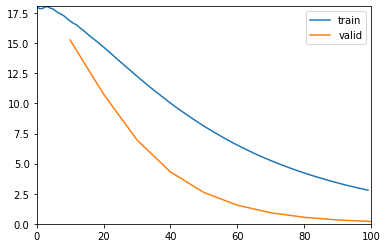

In [ ]:
#slow
learn = synth_learner(cbs=ShowGraphCallback())
learn.fit(5)

## CSVLogger -

In [ ]:
# export
class CSVLogger(Callback):
    run_after=Recorder
    "Log the results displayed in `learn.path/fname`"
    def __init__(self, fname='history.csv', append=False):
        self.fname,self.append = Path(fname),append

    def read_log(self):
        "Convenience method to quickly access the log."
        return pd.read_csv(self.path/self.fname)

    def before_fit(self):
        "Prepare file with metric names."
        self.path.parent.mkdir(parents=True, exist_ok=True)
        self.file = (self.path/self.fname).open('a' if self.append else 'w')
        self.file.write(','.join(self.recorder.metric_names) + '\n')
        self.old_logger,self.learn.logger = self.logger,self._write_line

    def _write_line(self, log):
        "Write a line with `log` and call the old logger."
        self.file.write(','.join([str(t) for t in log]) + '\n')
        self.old_logger(log)

    def after_fit(self):
        "Close the file and clean up."
        self.file.close()
        self.learn.logger = self.old_logger

The results are appended to an existing file if `append`, or they overwrite it otherwise.

In [ ]:
learn = synth_learner(cbs=CSVLogger())
learn.fit(5)

epoch,train_loss,valid_loss,time
0,19.039587,19.701471,00:00
1,16.735422,14.259439,00:00
2,14.151361,9.632797,00:00
3,11.720305,6.176662,00:00
4,9.583822,3.861699,00:00


In [ ]:
show_doc(CSVLogger.read_log)

<h4 id="CSVLogger.read_log" class="doc_header"><code>CSVLogger.read_log</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>CSVLogger.read_log</code>()

Convenience method to quickly access the log.

In [ ]:
df = learn.csv_logger.read_log()
test_eq(df.columns.values, learn.recorder.metric_names)
for i,v in enumerate(learn.recorder.values):
    test_close(df.iloc[i][:3], [i] + v)
os.remove(learn.path/learn.csv_logger.fname)

In [ ]:
show_doc(CSVLogger.before_fit)

<h4 id="CSVLogger.before_fit" class="doc_header"><code>CSVLogger.before_fit</code><a href="__main__.py#L12" class="source_link" style="float:right">[source]</a></h4>

> <code>CSVLogger.before_fit</code>()

Prepare file with metric names.

In [ ]:
show_doc(CSVLogger.after_fit)

<h4 id="CSVLogger.after_fit" class="doc_header"><code>CSVLogger.after_fit</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>CSVLogger.after_fit</code>()

Close the file and clean up.

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Converted 21_vision.l